In [1]:
%matplotlib inline
import os
import sys

from collections import OrderedDict
from copy import deepcopy
from time import time

import matplotlib.pyplot as plt
import numpy as np
import scipy.special as sc

import pymc3 as pm
import seaborn as sns
import theano
import theano.tensor as tt

from pymc3 import Dirichlet, Poisson, Gamma
from pymc3 import math as pmmath
# from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from theano import shared
from theano.sandbox.rng_mrg import MRG_RandomStreams

%env THEANO_FLAGS=device=cpu,floatX=float64


from data_prep import prepare_sparse_matrix

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


env: THEANO_FLAGS=device=cpu,floatX=float64


[nltk_data] Downloading package punkt to /home/liutianc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/liutianc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
n_words = 3000
n_samples = 10000

tf_vectorizer, docs_tr = prepare_sparse_matrix(n_samples, n_words)

In [3]:
feature_names = tf_vectorizer.get_feature_names()

In [91]:
avg_len

80.8287

In [4]:
n_tokens = np.sum(docs_tr[docs_tr.nonzero()])
n_tokens

808287

In [5]:
def log_prob(beta, theta):
    """Returns the log-likelihood function for given documents.

    K : number of topics in the model
    V : number of words (size of vocabulary)
    D : number of documents (in a mini-batch)

    Parameters
    ----------
    beta : tensor (K x V)
        Word distributions.
    theta : tensor (D x K)
        Topic distributions for documents.
    """

    def ll_docs_f(docs):
        
        dixs, vixs = docs.nonzero()
        vfreqs = docs[dixs, vixs]
        ll_docs = (
            vfreqs * pmmath.logsumexp(tt.log(theta[dixs]) + tt.log(beta.T[vixs]), axis=1).ravel()
        )

        # Per-word log-likelihood times num of tokens in the whole dataset
        return tt.sum(ll_docs) / (tt.sum(vfreqs) + 1e-9) * n_tokens

    return ll_docs_f

In [86]:
n_topics = 20
minibatch_size = 128

avg_len = docs_tr.sum(1).mean()

doc_t_minibatch = pm.Minibatch(docs_tr.toarray(), minibatch_size)
doc_t = shared(docs_tr.toarray()[:minibatch_size])


e0 = c0 = 1.
f0 = .01
pn = .5

with pm.Model() as model:
    theta = Dirichlet(
        "theta",
        a=pm.floatX((1.0 / n_topics) * np.ones((minibatch_size, n_topics))),
        shape=(minibatch_size, n_topics),
        total_size=n_samples,
    )
    
    beta = Dirichlet(
        "beta",
        a=pm.floatX((1.0 / n_topics) * np.ones((n_topics, n_words))),
        shape=(n_topics, n_words),
    )
    
    doc = pm.DensityDist("doc", log_prob(beta, theta), observed=doc_t)
    
#     step = pm.HamiltonianMC()
#     step = pm.Metropolis()
#     trace = pm.sample(1000, step)
    

/home/liutianc/miniconda3/lib/python3.7/site-packages/pymc3/data.py:246: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])
/home/liutianc/miniconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


# Evaluate Top words in each topic basd on the posterior mean.

In [88]:
class LDAEncoder:
    """Encode (term-frequency) document vectors to variational means and (log-transformed) stds."""

    def __init__(self, n_words, n_hidden, n_topics, p_corruption=0, random_seed=1):
        rng = np.random.RandomState(random_seed)
        self.n_words = n_words
        self.n_hidden = n_hidden
        self.n_topics = n_topics
        self.w0 = shared(0.01 * rng.randn(n_words, n_hidden).ravel(), name="w0")
        self.b0 = shared(0.01 * rng.randn(n_hidden), name="b0")
        
        self.w1 = shared(0.01 * rng.randn(n_hidden, n_hidden).ravel(), name="w1")
        self.b1 = shared(0.01 * rng.randn(n_hidden), name="b1")
        
        self.w2 = shared(0.01 * rng.randn(n_hidden, 2 * (n_topics - 1)).ravel(), name="w2")
        self.b2 = shared(0.01 * rng.randn(2 * (n_topics - 1)), name="b2")
        self.rng = MRG_RandomStreams(seed=random_seed)

    def encode(self, xs):

        w0 = self.w0.reshape((self.n_words, self.n_hidden))
        w1 = self.w1.reshape((self.n_hidden, self.n_hidden))
        w2 = self.w2.reshape((self.n_hidden, 2 * (self.n_topics - 1)))

        hs = tt.tanh(xs.dot(w0) + self.b0)
        hs = tt.tanh(hs.dot(w1) + self.b1)
        zs = hs.dot(w2) + self.b2
        zs_mean = zs[:, : (self.n_topics - 1)]
        zs_rho = zs[:, (self.n_topics - 1) :]
        return {"mu": zs_mean, "rho": zs_rho}

    def get_params(self):
        return [self.w0, self.b0, self.w1, self.b1, self.w2, self.b2]

In [89]:
encoder = LDAEncoder(n_words=n_words, n_hidden=100, n_topics=n_topics, p_corruption=0.0)
local_RVs = OrderedDict([(theta, encoder.encode(doc_t))])
# local_RVs

encoder_params = encoder.get_params()
encoder_params

[w0, b0, w1, b1, w2, b2]

In [90]:
η = .1
s = shared(η)


def reduce_rate(a, h, i):
    s.set_value(η / ((i / minibatch_size) + 1) ** 0.7)

with model:
    approx = pm.MeanField(local_rv=local_RVs)
    approx.scale_cost_to_minibatch = False
    inference = pm.KLqp(approx)
    
inference.fit(
    1000,
    callbacks=[reduce_rate, 
               pm.callbacks.CheckParametersConvergence(diff="absolute")],
    obj_optimizer=pm.adam(learning_rate=s),
    more_obj_params=encoder_params,
    total_grad_norm_constraint=200,
    more_replacements={doc_t: doc_t_minibatch},
)


  0%|          | 0/1000 [00:00<?, ?it/s]/home/liutianc/miniconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Average Loss = 1.0475e+07: 100%|██████████| 1000/1000 [04:00<00:00,  4.15it/s]
Finished [100%]: Average Loss = 1.0468e+07


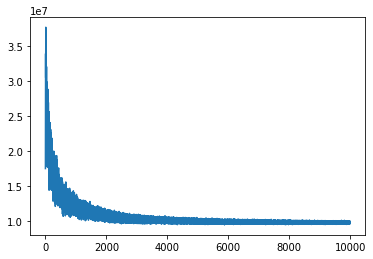

In [43]:
plt.plot(approx.hist[10:]);

In [44]:
def print_top_words(beta, feature_names, n_top_words=10):
    for i in range(len(beta)):
        print(
            ("Topic #%d: " % i)
            + " ,".join([feature_names[j] for j in beta[i].argsort()[: -n_top_words - 1 : -1]])
        )


doc_t.set_value(docs_tr.toarray())
samples = pm.sample_approx(approx, draws=100)
beta_pymc3 = samples["beta"].mean(axis=0)

print_top_words(beta_pymc3, feature_names)

Topic #0: like ,even ,bad ,good ,would ,really ,time ,see ,much ,get
Topic #1: good ,ever ,better ,even ,acting ,make ,people ,really ,boring ,also
Topic #2: bad ,good ,like ,could ,really ,even ,also ,actually ,fact ,made
Topic #3: good ,even ,like ,much ,better ,get ,bad ,characters ,actually ,audio
Topic #4: like ,good ,acting ,get ,much ,instead ,better ,bad ,make ,every
Topic #5: even ,ever ,bad ,also ,back ,character ,better ,certain ,cable ,good
Topic #6: bad ,find ,another ,anyone ,finally ,could ,actors ,able ,character ,back
Topic #7: even ,also ,bad ,could ,like ,good ,man ,believed ,dance ,ancient
Topic #8: even ,amateur ,back ,desperately ,bloody ,cousin ,etc ,attempts ,eat ,comedy
Topic #9: bad ,body ,course ,another ,actually ,away ,add ,common ,almost ,always
Topic #10: like ,acting ,best ,circumstances ,even ,family ,agreed ,cat ,bad ,angles
Topic #11: actually ,despite ,actors ,basically ,better ,get ,could ,end ,according ,angeles
Topic #12: get ,bad ,could ,even ,al

In [56]:
def calc_pp(ws, thetas, beta, wix):
    return ws * np.log(thetas.dot(beta[:, wix]))


def eval_lda(transform, beta, docs_te, wixs):
    """Evaluate LDA model by log predictive probability.

    Parameters
    ----------
    transform: Python function
        Transform document vectors to posterior mean of topic proportions.
    wixs: iterable of int
        Word indices to be held-out.
    """
    lpss = []
    docs_ = deepcopy(docs_te)
    thetass = []
    wss = []
    total_words = 0
    for wix in wixs:
        ws = docs_te[:, wix].ravel()
        if 0 < ws.sum():
            # Hold-out
            docs_[:, wix] = 0

            # Topic distributions
            thetas = transform(docs_)

            print(thetas.shape)
            raise ValueError()
            # Predictive log probability
            lpss.append(calc_pp(ws, thetas, beta, wix))

            docs_[:, wix] = ws
            thetass.append(thetas)
            wss.append(ws)
            total_words += ws.sum()
        else:
            thetass.append(None)
            wss.append(None)

    # Log-probability
    lp = np.sum(np.hstack(lpss)) / total_words

    return {"lp": lp, "thetass": thetass, "beta": beta, "wss": wss}

In [77]:
inp = tt.matrix(dtype="int64")
sample_vi_theta = theano.function(
    [inp], approx.sample_node(approx.model.theta, 100, more_replacements={doc_t: inp}).mean(0), 
)

sample_vi_n = theano.function(
    [inp], approx.sample_node(approx.model.beta, 100, more_replacements={doc_t: inp}).mean(0), 
)
# 

def transform_pymc3(docs):
    return sample_vi_theta(docs), sample_vi_n(docs)

/home/liutianc/miniconda3/lib/python3.7/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
/home/liutianc/miniconda3/lib/python3.7/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"


In [47]:
result_pymc3 = eval_lda(\
      transform_pymc3, beta_pymc3, docs_tr.toarray(), np.arange(100)\
  )

print("Predictive log prob (pm3) = {}".format(result_pymc3["lp"]))

Predictive log prob (pm3) = -7.13164636963113
